In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Variables
r_ball_m = 0.1066       # [m]
m_ball_kg = 0.28        # [kg]
rho_h20_kgpm3 = 997     # [kg/m^3]
coeff_drag = 0.5        # [unitless]

# Constants
g = 9.81    # [m/s^2]

# Derived values
cross_section_area_ball_m2 = np.pi*np.power(r_ball_m, 2)
volume_ball_m3 = (4/3)*np.pi*np.power(r_ball_m, 3)

force_buoyancy_N = rho_h20_kgpm3 * g * volume_ball_m3
force_g_N = m_ball_kg * g

In [3]:
time_points_sec = np.linspace(0, 0.1, 100)
delta_time_sec = time_points_sec[1] - time_points_sec[0]

velocity_values_mps = np.zeros_like(time_points_sec)
acceleration_values_mps2 = np.zeros_like(time_points_sec)
force_net_values_N = np.zeros_like(time_points_sec)

In [4]:
def calculate_velocity_mps(acceleration_mps2, delta_time_sec):
    return acceleration_mps2 * delta_time_sec

def calculate_force_drag_N(velocity_mps):
    return (1/2) * rho_h20_kgpm3 * np.power(velocity_mps, 2) * coeff_drag * cross_section_area_ball_m2

def calculate_force_net_N(time_point, velocity_value_mps):
    # No initial velocity, therefore no drag force at initial time (assumption)
    if time_point == 0.0: 
        return force_buoyancy_N - force_g_N

    force_drag_N = calculate_force_drag_N(velocity_value_mps)
    return force_buoyancy_N - (force_g_N + force_drag_N)

def calculate_acceleration_mps2(force_net_N):
    return force_net_N/m_ball_kg

In [5]:
for i in range(0, len(time_points_sec)):
    
    velocity_ball_mps = 0.0 
    if i > 0:
        velocity_ball_mps = calculate_velocity_mps(acceleration_values_mps2[i-1], delta_time_sec) + velocity_values_mps[i-1]
    
    velocity_values_mps[i] = velocity_ball_mps

    force_net_N = calculate_force_net_N(time_points_sec[i], velocity_ball_mps)
    force_net_values_N[i] = force_net_N

    acceleration_ball_mps2 = force_net_N/m_ball_kg
    acceleration_values_mps2[i] = acceleration_ball_mps2 

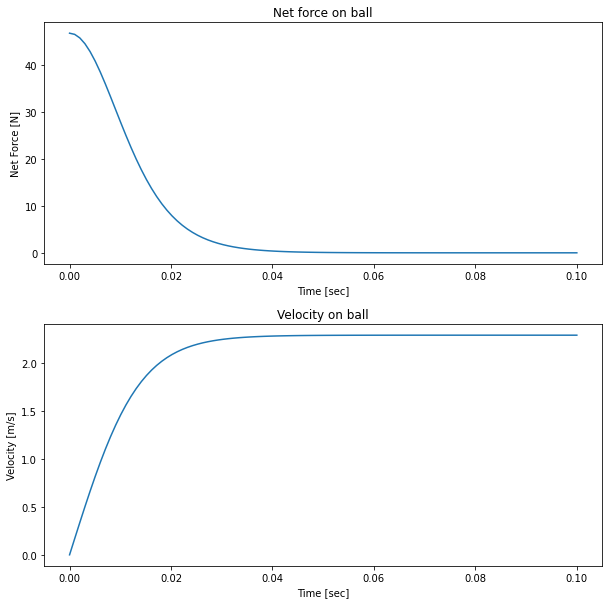

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(time_points_sec, force_net_values_N)
axs[0].set(title="Net force on ball", 
           xlabel="Time [sec]", 
           ylabel="Net Force [N]")

axs[1].plot(time_points_sec, velocity_values_mps)
axs[1].set(title="Velocity on ball",
           xlabel="Time [sec]",
           ylabel="Velocity [m/s]")

plt.subplots_adjust(wspace=0.25, hspace=0.25)


### Determining behavior at terminal velocity

In [ ]:
# Determining terminal velocity of ball underwater 
v_ball_mps_numerator = 2*(force_buoyancy_N - force_g_N)
v_ball_mps_denominator = rho_h20_kgpm3*coeff_drag*np.pi*np.power(r_ball_m, 2)
v_ball_mps = np.sqrt(v_ball_mps_numerator/v_ball_mps_denominator)
v_ball_mps_string = "{:.3f}".format(v_ball_mps)

print("Terminal velocity of ball: " + v_ball_mps_string + " m/s")